In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from matplotlib import pyplot as plt

Let's begin by exploring the number of electoral votes per state. 

In [2]:
#Create a pandas DataFrame with the electoral votes by state data
electoral_votes = pd.read_csv('electoral_votes_by_state.csv')

#Preview this DataFrame
print(electoral_votes.head(5))
print(electoral_votes.dtypes)

  code       state  num_electoral_votes
0   AL     ALABAMA                    9
1   AK      ALASKA                    3
2   AZ     ARIZONA                   11
3   AR    ARKANSAS                    6
4   CA  CALIFORNIA                   55
code                   object
state                  object
num_electoral_votes     int64
dtype: object


In [3]:
#Determine the total number of electoral votes
total_electoral_votes = electoral_votes['num_electoral_votes'].sum()

#Print the total number of electoral votes
print("There are a total of " + str(total_electoral_votes) + " electoral votes.")

There are a total of 538 electoral votes.


As we can see, there are a total of 538 electoral votes. Let's now look at the voting eligible population (VEP) and voting age population (VAP) in each state. 

In [4]:
#Create a pandas DataFrame with the 2020 turnout rate data
voting_population = pd.read_csv('2020_turnout_rates.csv')

#Remove the commas from the population numbers and convert them to numeric values
voting_population.replace(',','', regex=True, inplace=True)
voting_population['VAP'] = voting_population['VAP'].apply(pd.to_numeric,errors='coerce')
voting_population['VEP'] = voting_population['VEP'].apply(pd.to_numeric,errors='coerce')

#Preview this DataFrame and the type of data stored in each column
print(voting_population.head(10))
print(voting_population.dtypes)

                  State                                             Source  \
0               Alabama  https://www.sos.alabama.gov/sites/default/file...   
1                Alaska  https://www.elections.alaska.gov/results/20GEN...   
2               Arizona       https://results.arizona.vote/#/featured/18/0   
3              Arkansas  https://results.enr.clarityelections.com/AR/10...   
4            California                https://electionresults.sos.ca.gov/   
5              Colorado  https://results.enr.clarityelections.com/CO/10...   
6           Connecticut         https://ctemspublic.pcctg.net/#/selectTown   
7              Delaware  https://elections.delaware.gov/results/html/in...   
8  District of Columbia  https://electionresults.dcboe.org/election_res...   
9               Florida  https://floridaelectionwatch.gov/CountyReporti...   

   Official Total_Ballots_Counted Vote_For_Highest VEP_Turnout_Total  \
0  OFFICIAL               2325000          2323282            63.10% 

In [5]:
#Create a new DataFrame that only contains the state and its VEP
VEP = voting_population[['State', 'code', 'VEP']].copy()

#Rename the columns so that this population scheme can be passed into a function
VEP.columns = ['State', 'code', 'population']

#Preview the DataFrame
print(VEP.head(10))

                  State code  population
0               Alabama   AL     3683055
1                Alaska   AK      525568
2               Arizona   AZ     5189000
3              Arkansas   AR     2182375
4            California   CA    25962648
5              Colorado   CO     4313054
6           Connecticut   CT     2603327
7              Delaware   DE      720531
8  District of Columbia   DC      540685
9               Florida   FL    15551739


We'll utilize a function so that we can run the analysis again on other hypothetical breakdowns of electoral votes. 

In [6]:
#This function takes two data frames as arguments. The first data frame is an electoral college scheme (determining
#many electoral votes each state possesses) and the second data frame is the voting population (either VEP or VAP).

def analyze_voting_equity(electoral, population_data):
    
    #Determine the number of electoral votes in the electoral college scheme
    total_electoral_votes = electoral['num_electoral_votes'].sum()
    print("In this electoral college scheme, there are a total of " + str(total_electoral_votes) + " electoral votes.")
    
    #Determine the number of voters in the voting population scheme
    total_voters = population_data['population'].sum()
    print("Using this voting population data, there are a total of " + str(total_voters) + " voters.")
    
    #Compute the average voting power (i.e. how many voters would correspond to each electoral vote if 
    #votes were distributed equally amongst all voters)
    average_voting_power = int(round(total_voters / total_electoral_votes))
    print("If votes were distributed equitably, each electoral vote would correspond to approximately "
          + str(average_voting_power) + " people. Let's see how this compares to the actual distribution.")
    
    #Join the electoral college and voting power schemes on the state code column
    voting_power = population_data.join(electoral.set_index('code'), on='code')
    voting_power = voting_power[['State', 'code', 'population', 'num_electoral_votes']]
    #Add a column that computes voting power: number of voters divided by the number of electoral votes
    #This is the number of voters per electoral vote
    voting_power['voting_power'] = voting_power.apply(lambda row: round(row['population'] / row['num_electoral_votes']),axis=1)
    
    #Convert the voting power and state codes to lists so that they can be graphed
    power = np.array(voting_power['voting_power'].to_list())
    codes = voting_power['code'].to_list()
    
    #Create a threshold value which is the average voting power (this will be displayed as a dotted line on the graph)
    threshold = average_voting_power
    #The above_threshold and below_threshold variables allow us to color-code the portions of the bar graph that are above
    #and below the threshold dotted line
    above_threshold = np.maximum(power - threshold, 0)
    below_threshold = np.minimum(power, threshold)
    
    #Create a bar chart illustrating the voting power per state
    x = range(len(power))
    
    fig, ax = plt.subplots(figsize = (20,6))
    ax.bar(x, below_threshold, 0.35, color="g")
    ax.bar(x, above_threshold, 0.35, color="r",bottom=below_threshold)
    ax.plot([0,50],[threshold, threshold], "k--")
    ax.set_xticks(range(len(power)))
    ax.set_xticklabels(codes)
    plt.ylabel("Number of People per Electoral Vote")
    plt.xlabel("State")
    plt.show()
    
    #Create a new DataFrame that is sorted by voting power
    voting_power_sorted = voting_power.sort_values(by=['voting_power'])
    print(voting_power_sorted)
    
    #Look at descriptive statistics for the voting_power column
    print(voting_power.voting_power.describe())

In this electoral college scheme, there are a total of 538 electoral votes.
Using this voting population data, there are a total of 234632885 voters.
If votes were distributed equitably, each electoral vote would correspond to approximately 436121 people. Let's see how this compares to the actual distribution.


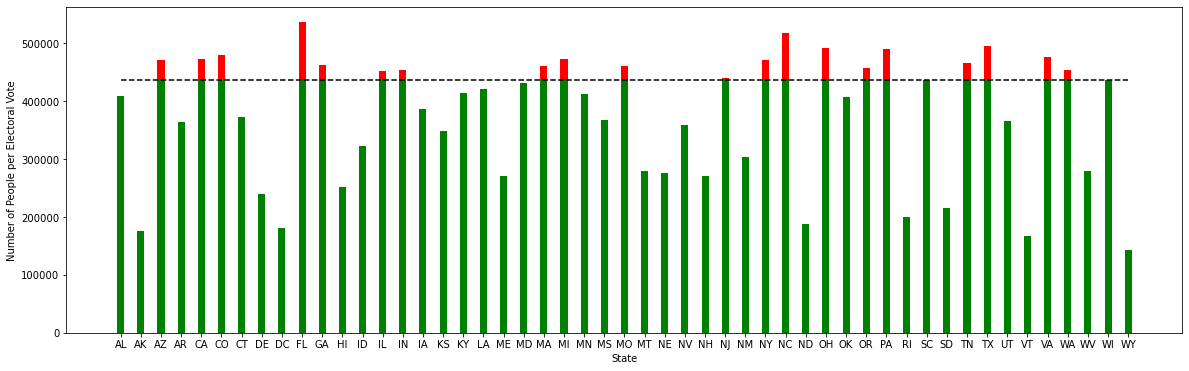

                   State code  population  num_electoral_votes  voting_power
50               Wyoming   WY      431364                    3        143788
45               Vermont   VT      499884                    3        166628
1                 Alaska   AK      525568                    3        175189
8   District of Columbia   DC      540685                    3        180228
34          North Dakota   ND      565143                    3        188381
39          Rhode Island   RI      799642                    4        199910
41          South Dakota   SD      648104                    3        216035
7               Delaware   DE      720531                    3        240177
11                Hawaii   HI     1007920                    4        251980
29         New Hampshire   NH     1079434                    4        269858
19                 Maine   ME     1085285                    4        271321
27              Nebraska   NE     1383551                    5        276710

In [7]:
#Run the voting equity function with the current electoral vote scheme and the VEP population data
analyze_voting_equity(electoral_votes, VEP)

In [15]:
#Create a new electoral college scheme to see if we can make it more equitable.
#Start with a copy of the VEP DataFrame (since our electoral college scheme will be population-based)
new_electoral = VEP.copy()
new_electoral = new_electoral[['code', 'State', 'population']]
new_electoral.columns = ['code', 'state', 'Population']

#add a column for number of electoral votes
#Choose the appropriate code if you want to round up, round down, or round traditionally

#round down
#new_electoral['num_electoral_votes'] = np.maximum(np.floor(new_electoral['Population'] / 436121),1)
#round up
#new_electoral['num_electoral_votes'] = np.ceil(new_electoral['Population'] / 436121)
#round traditionally
new_electoral['num_electoral_votes'] = round(new_electoral['Population'] / 436121)

In this electoral college scheme, there are a total of 535.0 electoral votes.
Using this voting population data, there are a total of 234632885 voters.
If votes were distributed equitably, each electoral vote would correspond to approximately 438566 people. Let's see how this compares to the actual distribution.


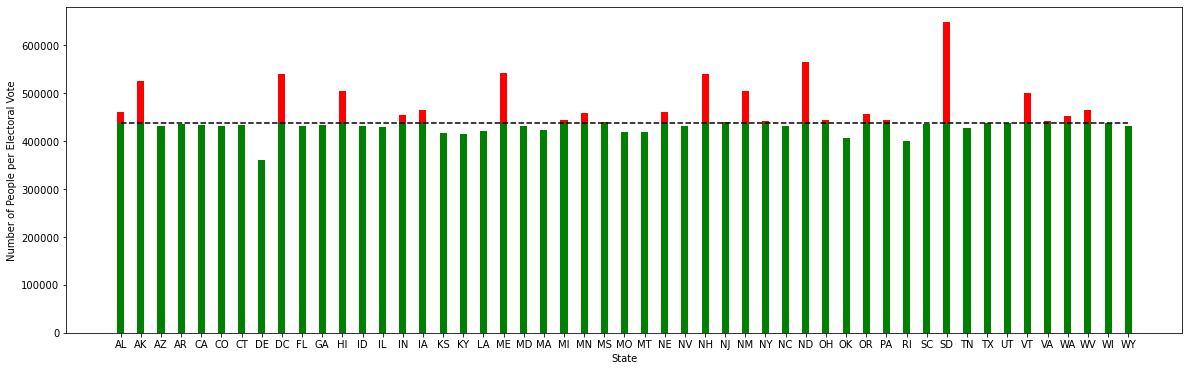

                   State code  population  num_electoral_votes  voting_power
7               Delaware   DE      720531                  2.0        360266
39          Rhode Island   RI      799642                  2.0        399821
36              Oklahoma   OK     2845835                  7.0        406548
17              Kentucky   KY     3312250                  8.0        414031
16                Kansas   KS     2087946                  5.0        417589
25              Missouri   MO     4603060                 11.0        418460
26               Montana   MT      837298                  2.0        418649
18             Louisiana   LA     3373932                  8.0        421742
21         Massachusetts   MA     5072901                 12.0        422742
42             Tennessee   TN     5124867                 12.0        427072
13              Illinois   IL     9027082                 21.0        429861
28                Nevada   NV     2153915                  5.0        430783

In [16]:
#Run the voting equity function with the new electoral college scheme and the VEP population data
analyze_voting_equity(new_electoral, VEP)